# Data Augmentation Pipeline

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as image
import skimage.io
from joblib import Parallel, delayed
from skimage import transform, morphology, color
import cv2
import tensorflow as tf

#### Konstanten

In [46]:
DATA_PATH = "../../../Pokemon-data/"
# Max 4 Chars
SUPPORTED_TYPES_LIST = [".png",".jpg","jpeg"]

#### Augmentation Funktionen

In [47]:
## Color Augmentation
def increase_red_color(img, increase):
    """Increase red component of an image
        img: input image
        increase: summand for the r channel values
    """
    for i in img:
        for j in i:
            if not (j[0] >= (255-increase)):
                j[0] += increase
            if not (j[1] <= increase):
                j[1] -= increase
            if not (j[2] <= increase):
                j[2] -= increase
    return img

# Increase green component of an image
def increase_green_color(img, increase):
    # Green is to agressive
    for i in img:
        for j in i:
            if not (j[1] >= (255-increase)):
                j[1] += increase
            if not (j[0] <= increase):
                j[0] -= increase
            if not (j[2] <= increase):
                j[2] -= increase
    return img


# Increase blue component of an image
def increase_blue_color(img, increase):
    for i in img:
        for j in i:
            if not (j[2] >= (255-increase)):
                j[2] += increase
            if not (j[1] <= increase):
                j[1] -= increase
            if not (j[0] <= increase):
                j[0] -= increase
    return img

# Increase random color component of an image
def img_increase_random_color(img):
    np.random.seed()
    increase = np.random.randint(25, 55)
    np.random.seed()
    color = np.random.randint(0, 3)

    if color == 0:
        return increase_red_color(img, increase)
    if color == 1:
        return increase_green_color(img, increase)
    if color == 2:
        return increase_blue_color(img, increase)

def img_dilation_or_color(img):
    np.random.seed()
    selection = np.random.randint(0, 5)
    if selection == 0:
        return img_dilation(img)
    if selection != 0:
        return img_increase_random_color(img)

# Shouldn't be combined with random image
def img_dilation(img):
    return morphology.dilation(img)

## Positional Augmentation
def img_random_rotation(img):
    np.random.seed()
    rotation_count = np.random.randint(0, 6)
    img = img.astype(np.uint8)
    return transform.rotate(img,(90*rotation_count))

def img_flip(img):
    return img[:,::-1,:]

def img_random_crop(img):
    np.random.seed()
    rand_size_factor_x = np.random.randint(0, 3)
    np.random.seed()
    rand_size_factor_y = np.random.randint(0,2)
    np.random.seed()
    rand_start_x = np.random.randint(1,20)
    np.random.seed()
    rand_start_x_s = np.random.randint(1,20)
    img = img[rand_start_x*rand_size_factor_x:175+(rand_size_factor_y*15), rand_start_x_s*rand_size_factor_x:175+(rand_size_factor_y*15),:]
    img = cv2.resize(img, (224,224))
    return img


#### Pipeline Hilfsfunktionen

In [48]:
# Helper functions
def get_all_images_for_label(label):
    return os.listdir(f"{DATA_PATH}/{label}")

def get_all_labels(data_path):
    return os.listdir(f"{data_path}")

def apply_augmentations(augmentation_functions,probability_list, img, target_shape):
    img = cv2.resize(img, target_shape)
    img = img[:,:,:3]
    for index, augmentation in enumerate(augmentation_functions):
        np.random.seed()
        if np.random.uniform(0,1) < probability_list[index]:
            img = augmentation(img)
    return img

def create_dir_structure(output_path, labels):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    for label in labels:
        label_path = f"{output_path}/{label}"
        if not os.path.exists(label_path):
            os.mkdir(label_path)

def load_image(path):
    return skimage.io.imread(path)

def save_result_to_folder(image_data, output_path, label, pkm_image_name):
    skimage.io.imsave(f"{output_path}{label}/{pkm_image_name}", image_data)

def create_path_list(data_path,labels):
    path_list = []
    for label in labels:
        for pkm_image in get_all_images_for_label(label):
            path_list.append(f"{data_path}{label}/{pkm_image}")
    return path_list

def run_pipeline_for_path(path, output_path, probability_list, strategy, strategy_params, augmentation_functions, target_shape):
    if path[-4:] in SUPPORTED_TYPES_LIST:
        img = load_image(path)
        if len(img.shape) == 3: 
            strategy(strategy_params=strategy_params,augmentation_functions=augmentation_functions,probability_list=probability_list, img=img, target_shape=target_shape,path=path, output_path=output_path)




#### Strategy-Funktionen

Base

In [42]:
def base_pre_strategy(strategy_params):
    return None

def base_strategy(strategy_params,augmentation_functions,probability_list, img, target_shape, path,output_path):
    parts = str(path).split("/")
    synth_image = apply_augmentations(augmentation_functions=augmentation_functions,probability_list=probability_list, img=img, target_shape=target_shape)
    save_result_to_folder(synth_image, output_path, parts[-2], parts[-1])

1.Strategy

In [57]:
def fetch_meta_info(strategy_params):
    metadata = pd.read_csv(strategy_params[0])
    pkm_df = metadata[["name","type1"]].loc[metadata["name"].isin(strategy_params[1])]
    improve_types_df = pkm_df["type1"].value_counts().loc[pkm_df["type1"].value_counts() <= pkm_df["type1"].value_counts()[0]]
    pkm_df = pkm_df.set_index(list(pkm_df)[0])
    pkm_dict = pkm_df.to_dict()['type1']
    return (pkm_dict,improve_types_df)
    
def fill_to_average(strategy_params,augmentation_functions,probability_list, img, target_shape, path,output_path):
    parts = str(path).split("/")
    label = parts[-2]
    pkm_dict, improve_types_df = strategy_params
    pkm_type = pkm_dict[label]
    average_value = improve_types_df[int(len(improve_types_df)/2)]
    lower_type = 1 if improve_types_df[pkm_type] < average_value else 0

    for i in range(0,1 + (lower_type * (improve_types_df[int(len(improve_types_df)/2)] - improve_types_df[pkm_type])) ):
        synth_image = apply_augmentations(augmentation_functions=augmentation_functions,probability_list=probability_list, img=img, target_shape=target_shape)
        image_name = parts[-1].split(".")
        image_name[-2] += f"_{i}"
        save_result_to_folder(synth_image, output_path, label, f"{image_name[-2]}.{image_name[-1]}")

#### Parallelisierte Pipeline

In [50]:
# Pipeline
# Possible extension -> Probability list
def augmentation_pipeline(augmentation_functions, probability_list, data_path,output_path,pre_strategy, strategy, strategy_params, target_shape=(224,224), num_workers=5):
    labels = get_all_labels(data_path)
    path_list = create_path_list(data_path,labels)
    strategy_params = pre_strategy(strategy_params)
    create_dir_structure(output_path, labels)
    _ = Parallel(n_jobs=num_workers)(delayed(run_pipeline_for_path)(path=path, output_path=output_path,
        probability_list=probability_list, 
        strategy=strategy,
        strategy_params=strategy_params,
        augmentation_functions=augmentation_functions,
        target_shape=target_shape) for path in path_list) 


#### Pipeline 1: Wenig

- increase random color takes long


In [58]:
labels = get_all_labels(data_path=DATA_PATH)
augmentation_pipeline(augmentation_functions=[img_flip, img_random_crop],probability_list=[0.3,0.8],strategy=fill_to_average,pre_strategy=fetch_meta_info, strategy_params=("../metadata/pokemon.csv",labels), data_path=DATA_PATH, output_path="../../../pipeline_one/",target_shape=(224,224), num_workers=15)

#### Pipeline 2: Mittel

In [202]:
labels = get_all_labels(data_path=DATA_PATH)
augmentation_pipeline(augmentation_functions=[img_random_rotation, img_increase_random_color, img_random_crop],probability_list=[0.5,0.6,0.8],strategy=fill_to_average,pre_strategy=fetch_meta_info, strategy_params=("../metadata/pokemon.csv",labels), data_path=DATA_PATH, output_path="../../../pipeline_one/",target_shape=(224,224), num_workers=15)

#### Pipeline 3: Viel

In [203]:
labels = get_all_labels(data_path=DATA_PATH)
augmentation_pipeline(augmentation_functions=[img_flip,img_random_rotation,img_dilation_or_color,img_random_crop],probability_list=[0.5,0.5,0.8,0.8],strategy=fill_to_average,pre_strategy=fetch_meta_info, strategy_params=("../metadata/pokemon.csv",labels), data_path=DATA_PATH, output_path="../../../pipeline_one/",target_shape=(224,224), num_workers=15)

Compare: Before/After Strategy

In [11]:
labels = get_all_labels(data_path=DATA_PATH)
metadata = pd.read_csv("metadata/pokemon.csv")
pkm_df = metadata[["name","type1"]].loc[metadata["name"].isin(labels)]
pkm_df = pkm_df.set_index(list(pkm_df)[0])
pkm_dict = pkm_df.to_dict()['type1']

def count_labels(eval_path, pkm_dict):
    distribution_dict = {}
    for label in os.listdir(eval_path):
        distribution_dict[pkm_dict[label]] = 0
    for label in os.listdir(eval_path):
        distribution_dict[pkm_dict[label]] = len(os.listdir(f"{eval_path}{label}")) + distribution_dict[pkm_dict[label]]
    return distribution_dict
        

<BarContainer object of 15 artists>

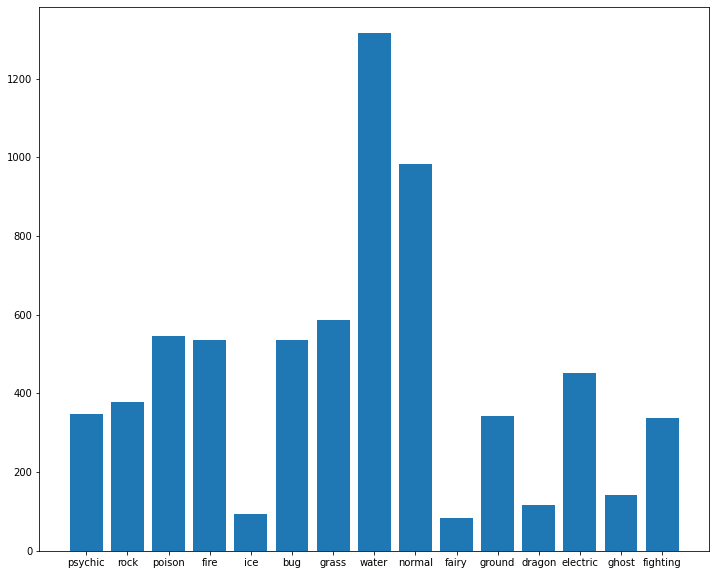

In [12]:
# Before
result_dict = count_labels(DATA_PATH, pkm_dict=pkm_dict)
plt.figure(figsize=(12,10))
plt.bar(x=result_dict.keys(), height=result_dict.values())


<BarContainer object of 15 artists>

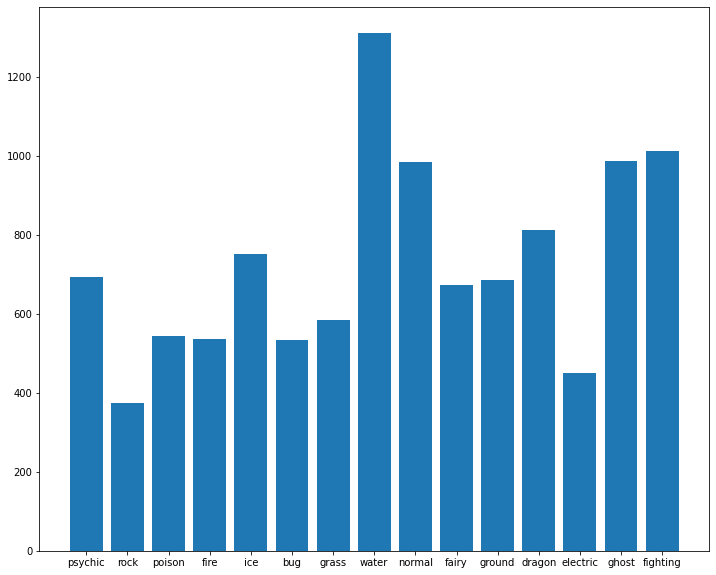

In [13]:
# After
result_dict = count_labels("../../pipeline_one/", pkm_dict=pkm_dict)
plt.figure(figsize=(12,10))
plt.bar(x=result_dict.keys(), height=result_dict.values())


#### Testbereich

In [15]:
labels = get_all_labels(data_path=DATA_PATH)

Tests - Strategie

In [11]:
metadata = pd.read_csv("../metadata/pokemon.csv")

In [12]:
pkm_df = metadata[["name","type1"]].loc[metadata["name"].isin(labels)]
#improve_types_df = pkm_df["type1"].value_counts().loc[pkm_df["type1"].value_counts() <= pkm_df["type1"].value_counts()[0]/2]
improve_types_df = pkm_df["type1"].value_counts().loc[pkm_df["type1"].value_counts() <= pkm_df["type1"].value_counts()[0]]

In [299]:
1 if improve_types_df["water"] < 12 else 0

0

In [300]:
int(len(improve_types_df)/2)

7

In [ ]:
pkm_df = pkm_df.set_index(list(pkm_df)[0])
pkm_dict = pkm_df.to_dict()['type1']
pkm_dict

In [13]:
improve_types_df[0] - improve_types_df["fire"]

16

Tests - Augmentation

(210, 218, 3)
uint8


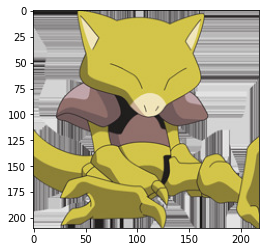

In [16]:
elements = os.listdir(f"{DATA_PATH}/{labels[0]}")
img = mpimg.imread(f"{DATA_PATH}/{labels[0]}/{elements[9]}")
imgplot = plt.imshow(img)
print(img.shape)
print(img.dtype)
plt.show()

(900, 900, 4)
uint8


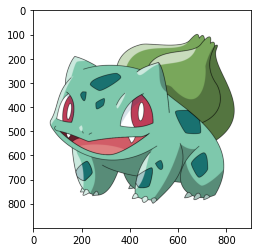

In [18]:
elements = os.listdir(f"{DATA_PATH}/{labels[0]}")
img = skimage.io.imread(f"../../../Pokemon-data/Bulbasaur/00000000.png")
imgplot = plt.imshow(img)
print(img.shape)
print(img.dtype)
plt.show()

In [19]:
path = f"../../Pokemon-data/Slowbro/Screen Shot 2019-08-12 at 83439 PM.png"
#path = f"../../Pokemon-data/Slowbro/Screen Shot 2019-08-12 at 8.34.39 PM.png"
parts = str(path).split("/")
print(parts)

image_name = parts[4].split(".")
image_name[-2] += f"_{0}"

print(image_name)

['..', '..', 'Pokemon-data', 'Slowbro', 'Screen Shot 2019-08-12 at 83439 PM.png']
['Screen Shot 2019-08-12 at 83439 PM_0', 'png']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input shape: (210, 218, 3)
Removed alpha shape: (210, 218, 3)
Applied resize shape: (224, 224, 3)


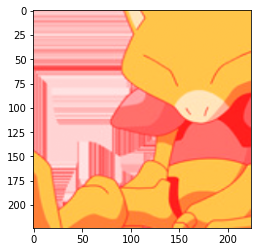

In [20]:

img = load_image(f"{DATA_PATH}/{labels[0]}/{elements[9]}")
img = img.astype(np.uint8)
print(f"Input shape: {img.shape}")
print(f"Removed alpha shape: {img.shape}")

img = img[25:175, 80:230,:]
img = cv2.resize(img, (224,224))
print(f"Applied resize shape: {img.shape}")

img = transform.rotate(img,90.0*np.random.randint(0,6))
img = img_increase_random_color(img)

img = img_flip(img)
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input shape: (210, 218, 3)
Removed alpha shape: (210, 218, 3)
Applied resize shape: (224, 224, 3)


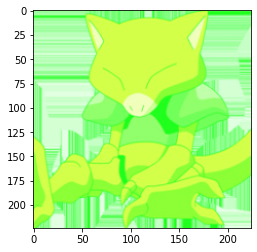

In [21]:
# Test some data augmentation techniques
img = load_image(f"{DATA_PATH}/{labels[0]}/{elements[9]}")
img = img.astype(np.uint8)
print(f"Input shape: {img.shape}")
print(f"Removed alpha shape: {img.shape}")
img = cv2.resize(img, (224,224))
print(f"Applied resize shape: {img.shape}")

img = transform.rotate(img,90.0*np.random.randint(0,6))
img = img_increase_random_color(img)

img = img_flip(img)
plt.imshow(img)
plt.show()

(224, 224, 3)


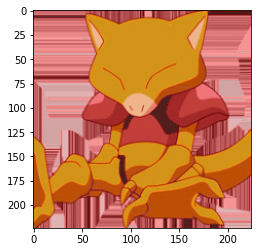

In [22]:
# Test some data augmentation techniques
img = load_image(f"{DATA_PATH}/{labels[0]}/{elements[9]}")
img = cv2.resize(img, (224,224))
print(img.shape)
img = img_increase_random_color(img)
img = img_random_rotation(img)
img = img_flip(img)
plt.imshow(img)
plt.show()

(224, 224, 3)


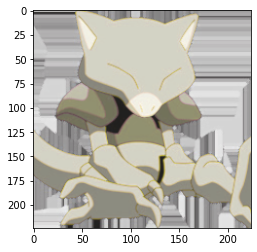

In [39]:
# Test some data augmentation techniques
img = load_image(f"{DATA_PATH}/{labels[0]}/{elements[9]}")
img = cv2.resize(img, (224,224))
print(img.shape)
img = img_dilation_or_color(img)
plt.imshow(img)
plt.show()

In [218]:
labels = get_all_labels(DATA_PATH)
path_list = create_path_list(DATA_PATH,labels)
for path in path_list:
    if path[-4:] in SUPPORTED_TYPES_LIST:
        img = load_image(path)
        img = cv2.resize(img, (224,224))
        if type(img) != "unit8":
            #print(img.dtype)
            pass

In [ ]:
labels = get_all_labels(DATA_PATH)
path_list = create_path_list(DATA_PATH,labels)
for path in path_list:
    if path[-4:] in SUPPORTED_TYPES_LIST:
        img = load_image(path)
        img = cv2.resize(img, (224,224))
        shapetest = img.shape
        if shapetest != (224,224,3):
            
            print(path)
            print(shapetest)
            print(len(img.shape))

In [220]:
test = f"../../Pokemon-data/Bulbasaur/00000000.png".split("/")
ret = test[-1].split(".")
ret[0] += "_1"
print(f"{ret[0]}.{ret[1]}")

00000000_1.png
